# CS-401: Milestone P2

This notebook aims to provide a basic primary pre-processing and analysis of datasets that we will be using. The pre-processing pipeline is divided into three parts: loading, cleaning and merging. One can have a look of this pipeline in the `preprocessing` folder. For more information, look at the `README`.

**Content of this notebook**
- [Data Processing](#preprocessing)
  - [Loading datasets](#1-load-the-data)
  - [Cleaning](#2-basic-cleaning)
  - [Merging](#3-merging-all-datasets)
- [Basic Statistical Analysis](#exploratory--basic-analysis)
  - [Handling Outlier](#1-outliers-removal)
  - [Missing values analysis](#2-missing-values-analysis)
  - [Key features' distribution](#3-distribution-of-key-features)
  - [Rating vs Number of actress](#4-is-there-a-link-between-popularity-and-proportion-of-women-in-a-movie)
  - [Age analysis](#5-is-there-a-difference-in-age-for-women)
  - [Bechdel Test](#6-bechdel-test)
- [Basic NLP on Summaries](#nlp-on-plot-summaries)
  - [Preprocessing and Tokenization](#1-preprocessing-of-the-texts-and-cleaning)
  - [Feminity Score](#2-feminity-score-analysis)


---

In [4]:
import sys

sys.path.append("./preprocessing")
sys.path.append("./analysis")
sys.path.append("./nlp")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

# Our tools (see python files in preprocessing and analysis)
import loader
import cleaner
import merger
import visualizer as viz
import nlp_utils as nlputils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing

**Skip this part and load the data directly. 
Cleaning and merging the data include scraping and can take several hours.**

## 1. Load the data

We first start by loading datasets. CMU dataset is loaded as well as external dataset like Bechdel and TMDB dataset since these will be useful later for a more in-depth analysis.

In [5]:
# =============== LOADER =============== #
# CMU Dataset
character_df, movie_df = loader.load_CMU_dataset()
summaries_df = loader.load_summaries()

# External Dataset
bechdel_df = loader.load_bechdel_dataset()
credits_df, meta_df = loader.load_tmdb_dataset()

FileNotFoundError: [Errno 2] No such file or directory: './data/MovieSummaries/character.metadata.tsv'

## 2. Basic cleaning

Here, we perform basic data cleaning operations on dataframes, such as renaming columns and converting date strings into Python datetime objects. To handle the credits dataframe, you can refer to the [clean_credit_df function](./preprocessing/cleaner.py#clean_credit_df). Our objective is to analyze women's representation in the film industry, and to do this, we require information about the gender of the crew members for movies. We observed that this information was frequently missing, while full names were always provided. As a solution, we utilized the `genderguesser` package to predict the gender based on the first name. This approach allows us to reduce the number of ungendered samples without discarding entire rows.

In [ ]:
# =============== CLEAN =============== #
# Clean datasets

movie_df = cleaner.clean_movie_df(movie_df)
bechdel_df = cleaner.clean_bechdel_df(bechdel_df)
credits_df = cleaner.clean_credit_df(credits_df, meta_df, scraping=True)
meta_df = cleaner.clean_metadata_df(meta_df)

## 3. Merging all datasets

In this step, we combine all our datasets to create a final dataset named `movies`, which will contain all the necessary features for our analysis.

In [ ]:
# =============== MERGE =============== #
# Merge datasets
movies = merger.merge_with_char(movie_df, character_df)
movies = merger.merge_with_summaries(movies, summaries_df)
movies = merger.merge_with_metadata(movies, meta_df)
movies = merger.merge_with_credits(movies, credits_df)

# Put the actor_name column at the beginning since we have one row per actor name
movies = movies.reindex(
    columns=["actor_name"] + [col for col in movies.columns if col != "actor_name"]
)
display(movies.sample(5))

# It will be useful when we will analyze the effect of the bechdel score rating on
# the women's representation in movies
movies_with_bechdel = merger.merge_with_bechdel(movies, bechdel_df)

4. Load clean and merged copy

In [6]:
# Alternatively:
# You can directly load full cleaned and merged data
movies = pd.read_pickle("./data/Processed/movies_cleaned.pkl")
movies_with_bechdel = pd.read_pickle("./data/Processed/movies_with_bechdel.pkl")

---

# Exploratory & Basic Analysis

Now, let's explore and try to understand the data. 

## 1. Outliers removal

In [7]:
movies.drop(columns=["wikiID"]).describe()

,movie_bo_revenue,movie_runtime,year,actor_height_meters,actor_age_at_movie_release,vote_average
count,7.191300e+04,124760.000000,126290.000000,61081.000000,97620.000000,126290.000000
mean,8.389626e+07,106.590008,1991.207182,1.794253,38.528396,6.075294
std,1.567086e+08,26.240080,20.838320,4.238687,14.559805,1.147225
min,1.140800e+04,1.250000,1902.000000,0.610000,-81.000000,0.000000
25%,7.724701e+06,92.000000,1983.000000,1.680000,28.000000,5.500000
50%,2.807807e+07,102.000000,1999.000000,1.760000,37.000000,6.200000
75%,9.075381e+07,116.000000,2006.000000,1.830000,48.000000,6.800000
max,2.782275e+09,1003.000000,2014.000000,510.000000,96.000000,10.000000


As one can see, there are outliers and dirty samples in the data: negative actor's ages, movies of 16h long, ... 
We will remove them in the next cell, outliers will be remove by quantile method (see [here](./preprocessing/cleaner.py#clean_remove_outlier))

In [8]:
movies = cleaner.clean_movies_ranges(movies)
movies = cleaner.clean_remove_outlier(
    movies, method="quantile", name="actor_height_meters"
)
movies = cleaner.clean_remove_outlier(movies, method="quantile", name="movie_runtime")

movies.drop(columns=["wikiID"]).describe()

,movie_bo_revenue,movie_runtime,year,actor_height_meters,actor_age_at_movie_release,vote_average
count,3.845700e+04,57103.000000,57103.000000,57103.000000,55424.000000,57103.000000
mean,8.787368e+07,104.780915,1993.432184,1.756534,37.942895,6.018703
std,1.465971e+08,16.421360,18.293721,0.099834,13.892007,1.063204
min,1.263600e+04,57.000000,1914.000000,1.470000,0.000000,0.000000
25%,9.493259e+06,93.000000,1988.000000,1.680000,28.000000,5.500000
50%,3.238238e+07,102.000000,1999.000000,1.760000,36.000000,6.100000
75%,9.841006e+07,115.000000,2006.000000,1.830000,46.000000,6.700000
max,1.511758e+09,153.000000,2012.000000,2.050000,95.000000,10.000000


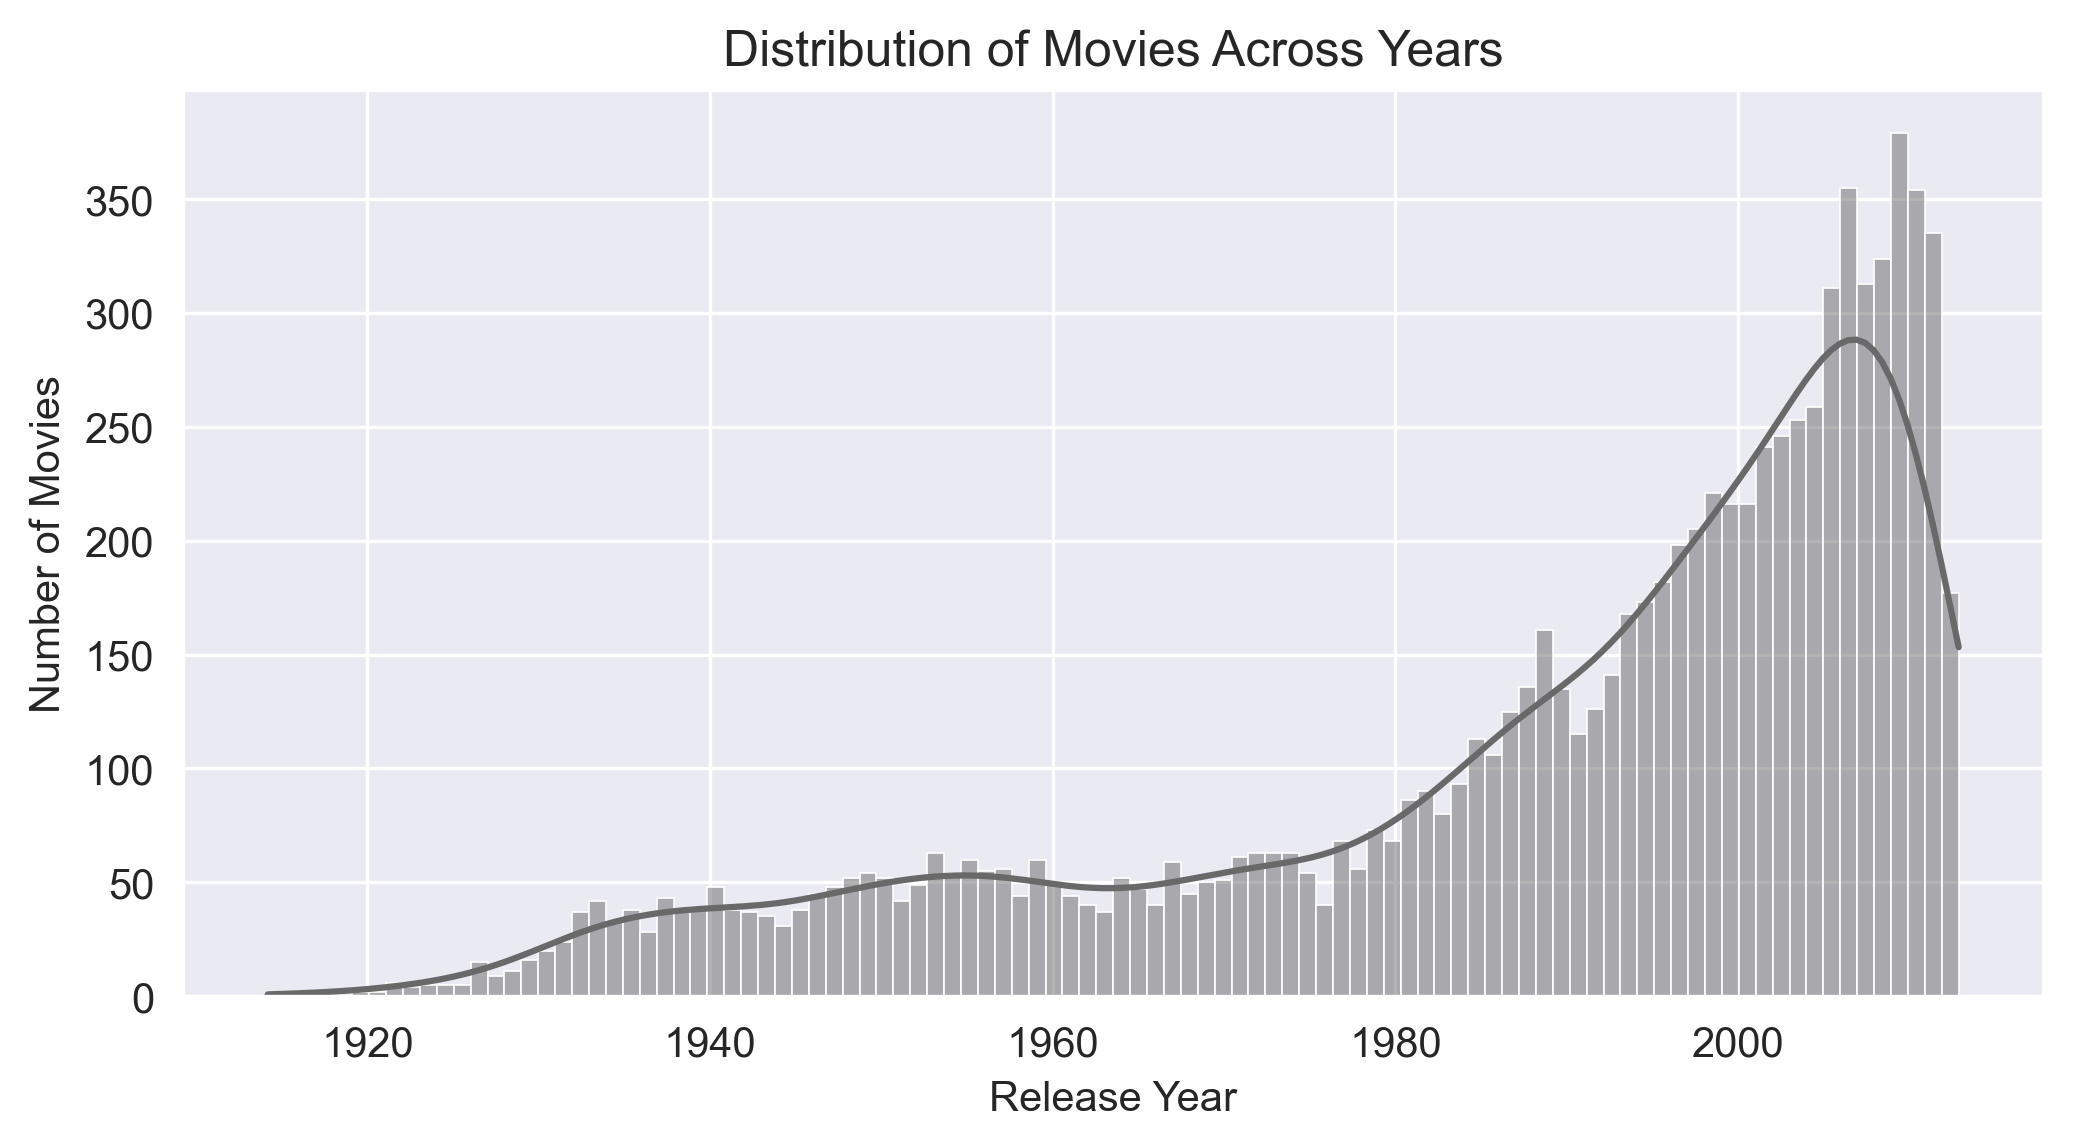

Total number of movies:  9146
Mean number of movies per year: 93


In [9]:
viz.visualize_year_distribution(movies)

With this cleaning, we are sure to have at least around 50 movies per year, from year 1935. 

## 2. Missing values analysis

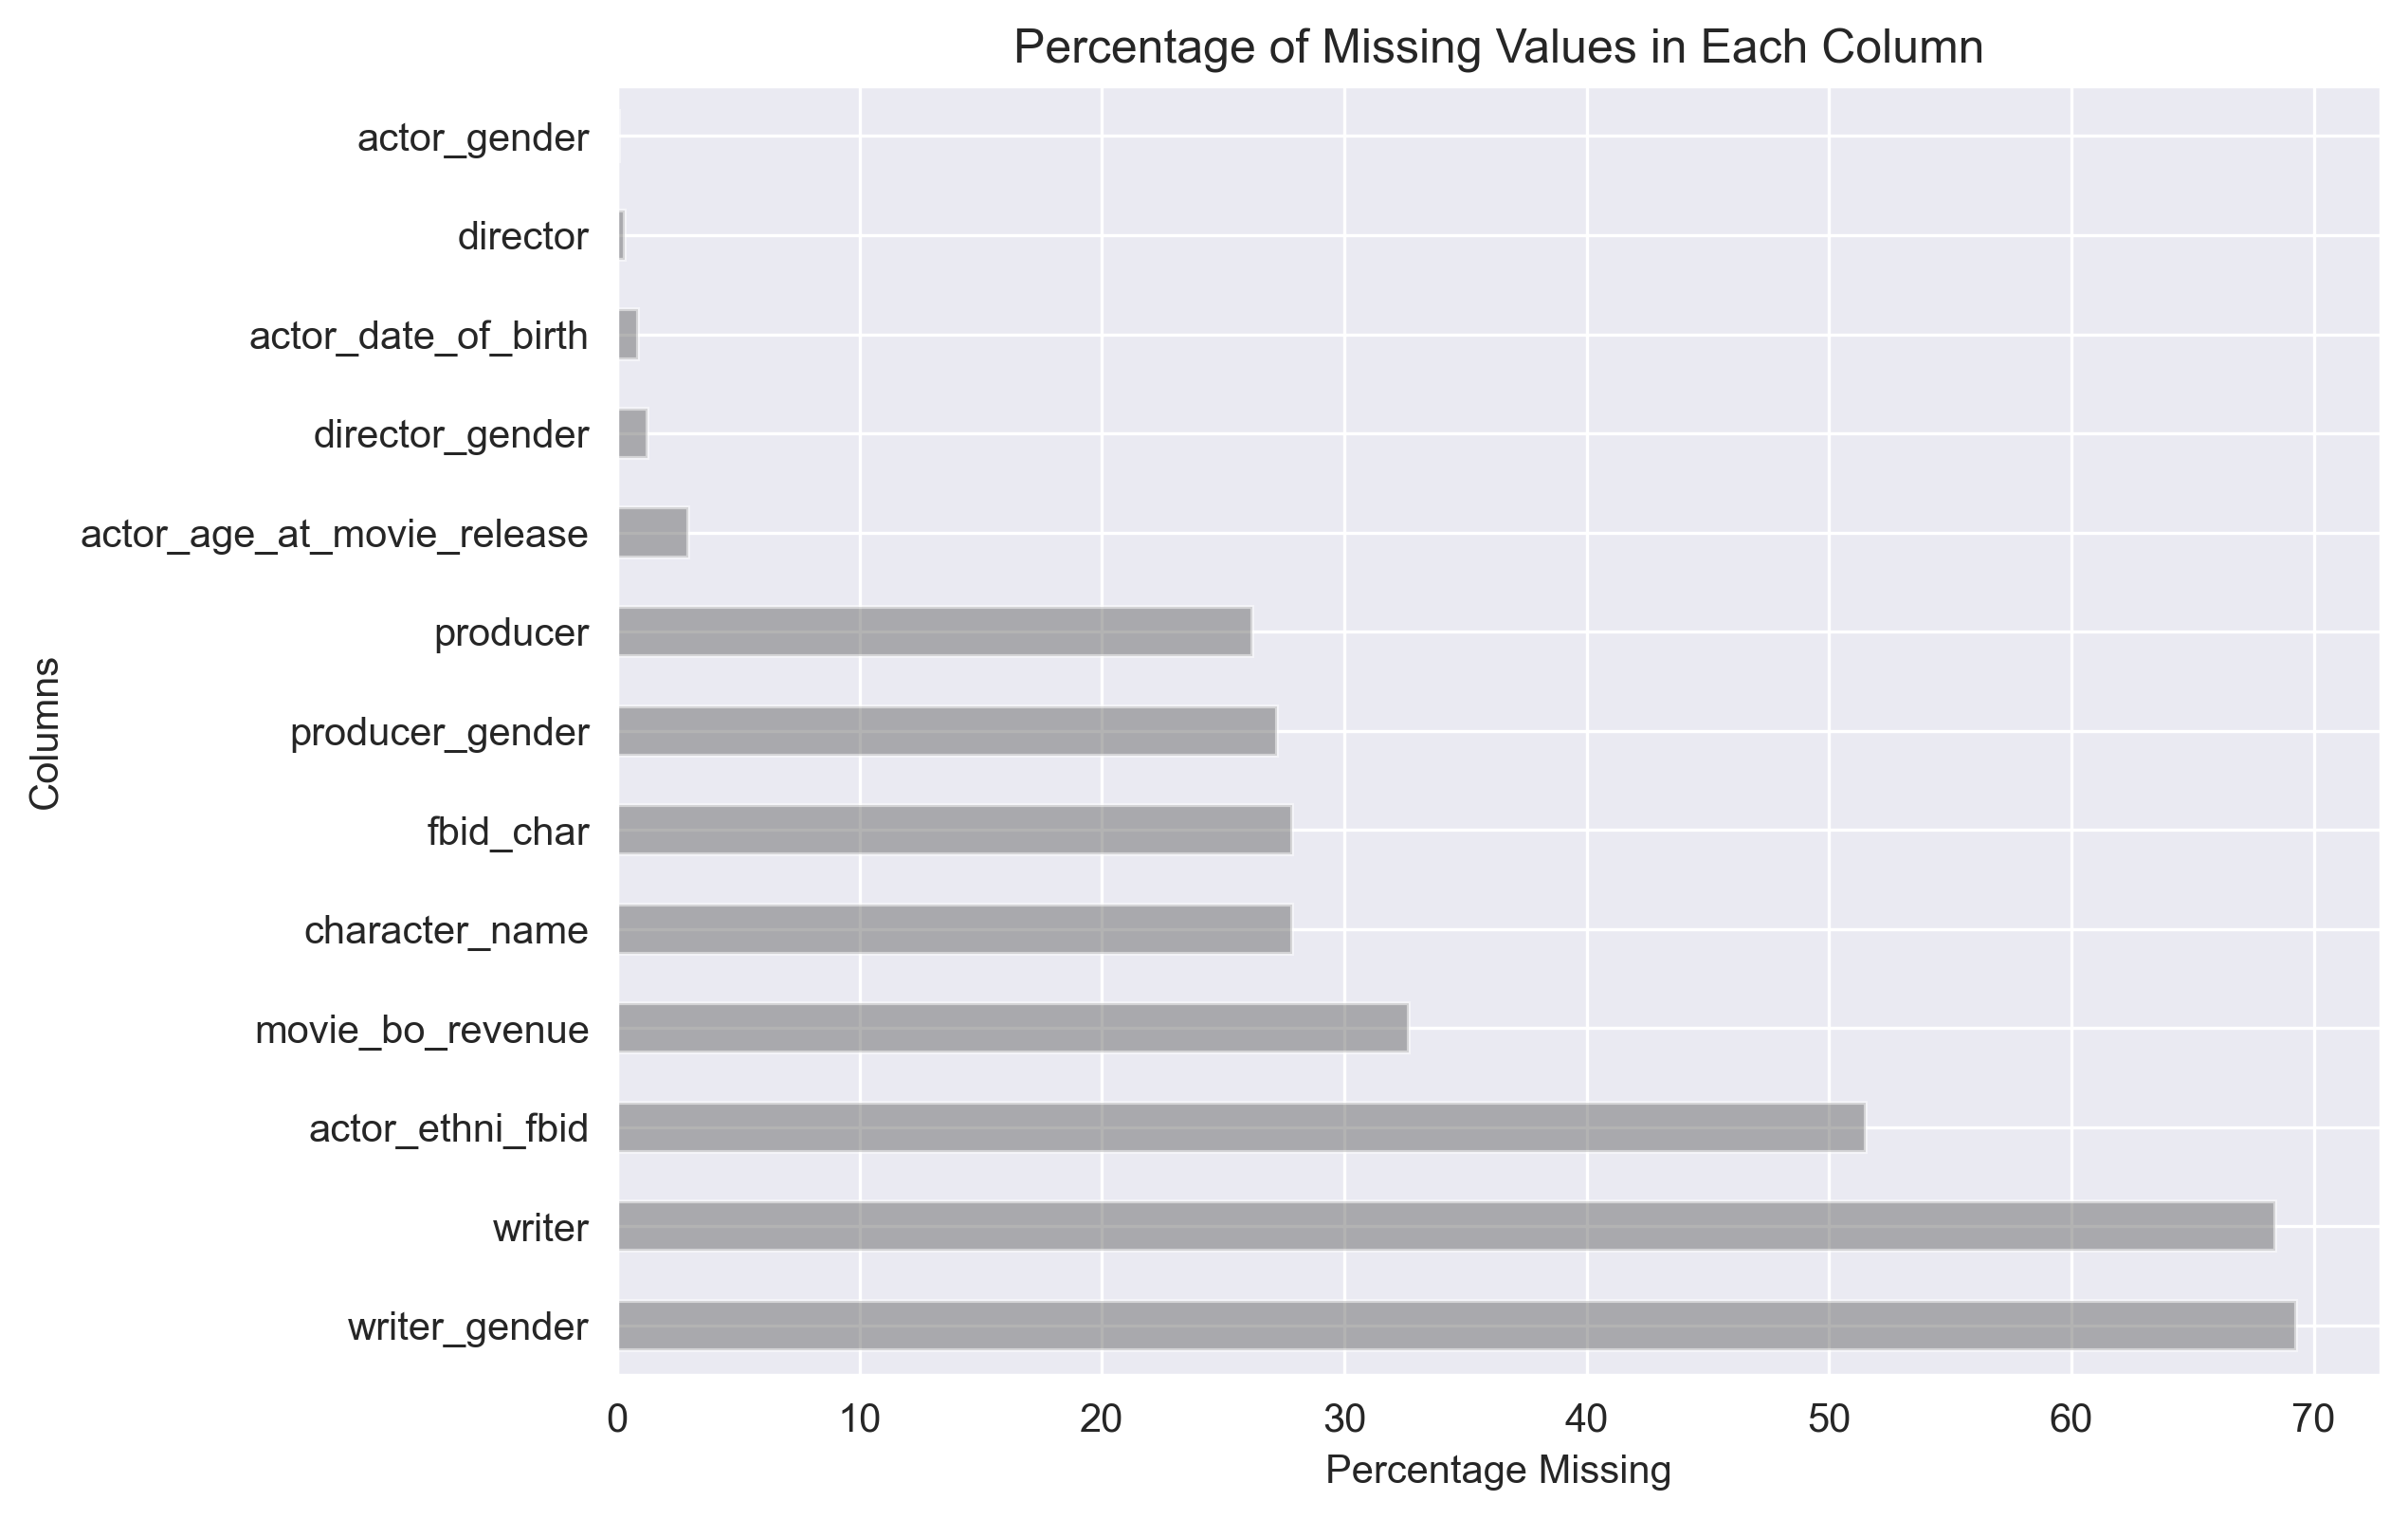

In [10]:
viz.visualize_missing_values(movies)

<div align="justify">

Based on the previous plot, it is evident that there are numerous missing values for the `writer` and `writer_gender` features. Given their limited usability due to this, it's necessary to remove them. Additionally, the `actor_ethni_fbid` feature, which would not have been utilized regardless, should also be dropped.

This correspond to dropping colums with more than 50% of missing values.

</div>

In [11]:
movies = cleaner.clean_missing_values_by_dropping(
    movies, to_drop=["writer", "writer_gender", "actor_ethni_fbid"]
)
display(movies.sample(2))

,actor_name,wikiID,freebaseID,movie_title,movie_release_date,movie_bo_revenue,movie_runtime,fbid_languages,fbid_countries,fbid_genres,...,summary,budget,popularity,vote_average,imdbid,id,director,director_gender,producer,producer_gender
20324,Tommy Morrison,153435,/m/0140g4,Rocky V,1990-11-16,119946358.0,110.0,[English Language],[United States of America],"[Sports, Action, Melodrama, Drama, Boxing]",...,"Rocky Balboa and his trainer Tony ""Duke"" Ever...",42000000,14.007329,5.3,0100507,1375,John G. Avildsen,M,Robert Chartoff,M
2508,Cybill Shepherd,74868,/m/0jym0,The Last Picture Show,1971-10-03,29133000.0,126.0,[English Language],[United States of America],"[Ensemble Film, Slice of life story, Americana...",...,"In 1951, Sonny Crawford and Duane Jackson ar...",1300000,5.961382,7.6,0067328,25188,Peter Bogdanovich,M,NaN,NaN


Now our dataset is cleaned and useable!

## 3. Distribution of Key Features

In this section, we will examine the distribution of women in various sectors of the movie industry. To begin, let's visualize the distribution of men and women across three roles: actors, film directors, and producers.

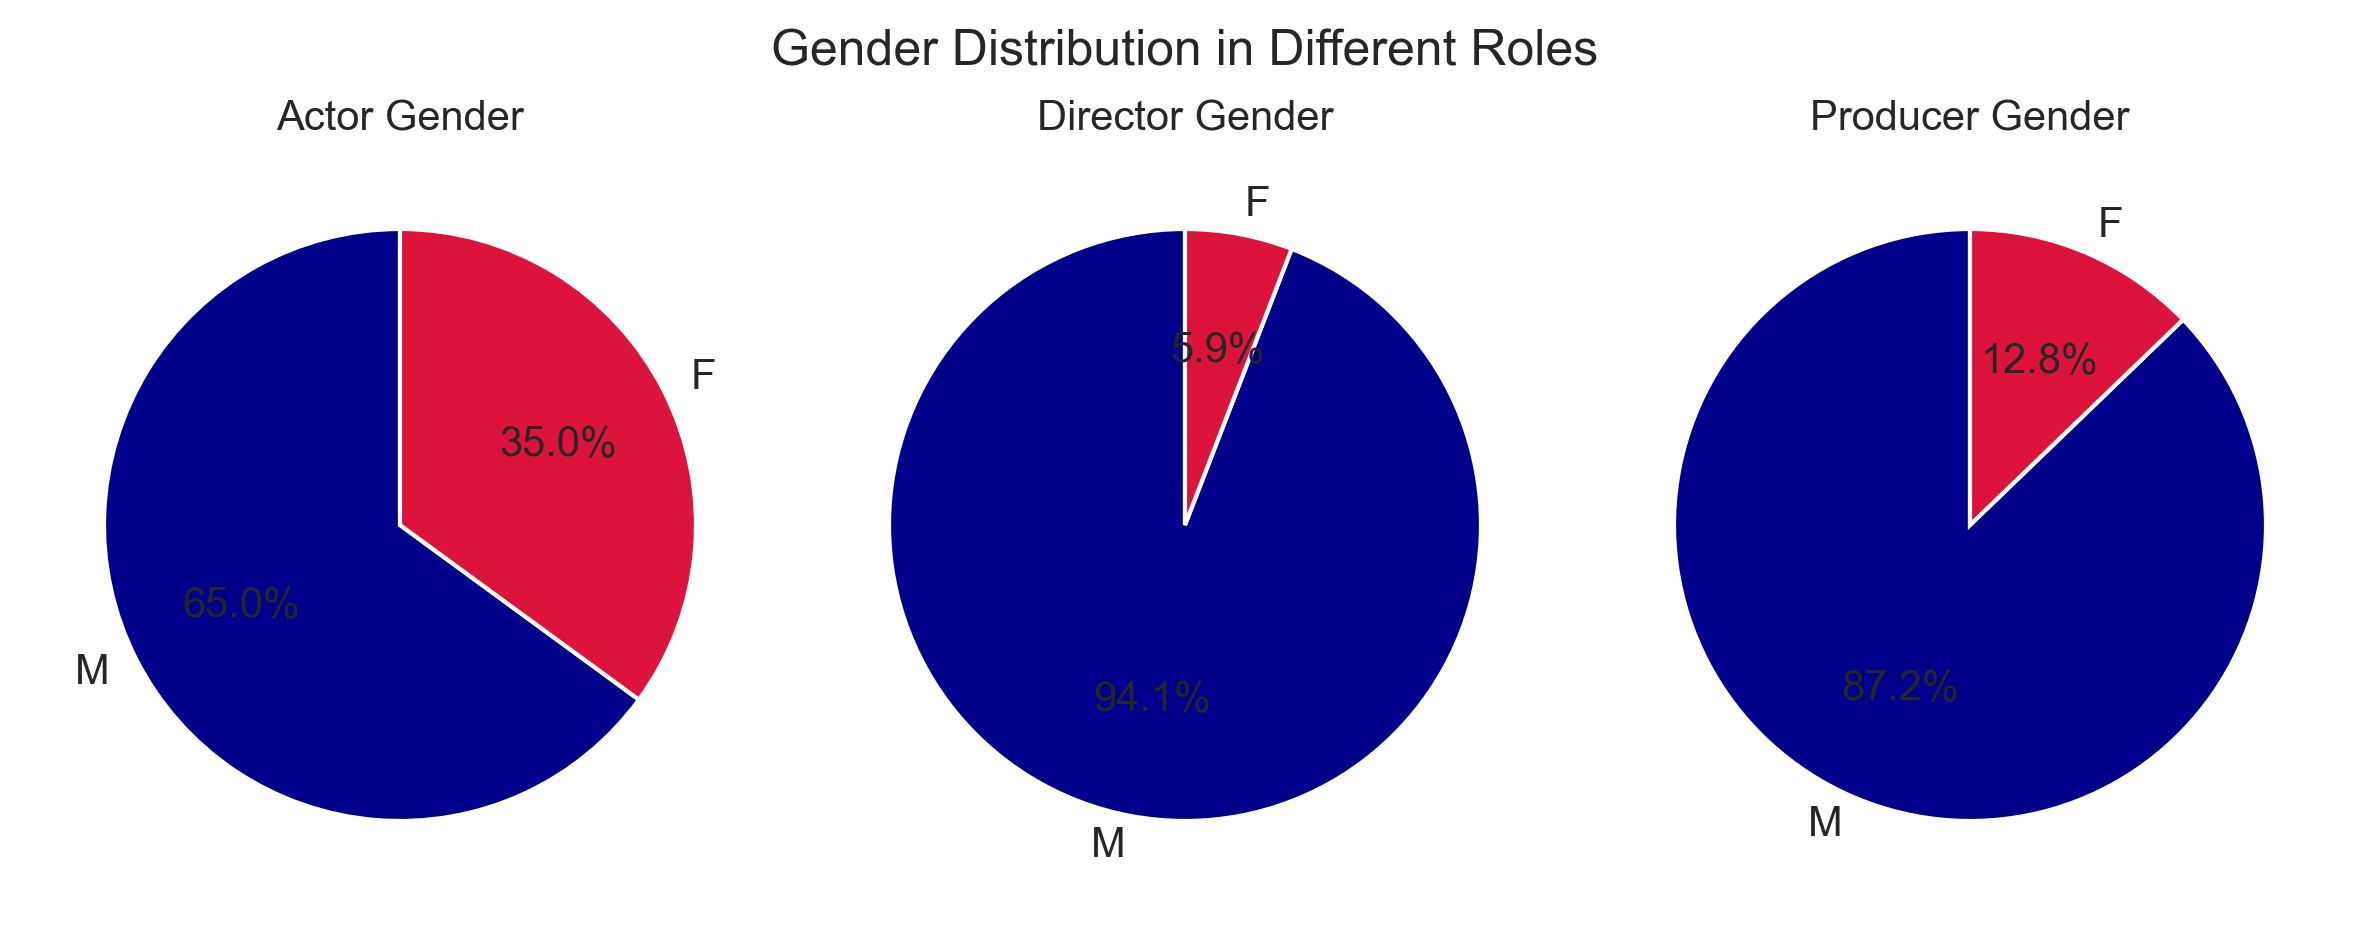

In [12]:
viz.visualize_gender_distribution(movies)

One can clearly see that women are underrepresented both in front of the camera and behind the scenes. Actually, they are much less represented behind the camera than in front of it. This is a first interesting observation.

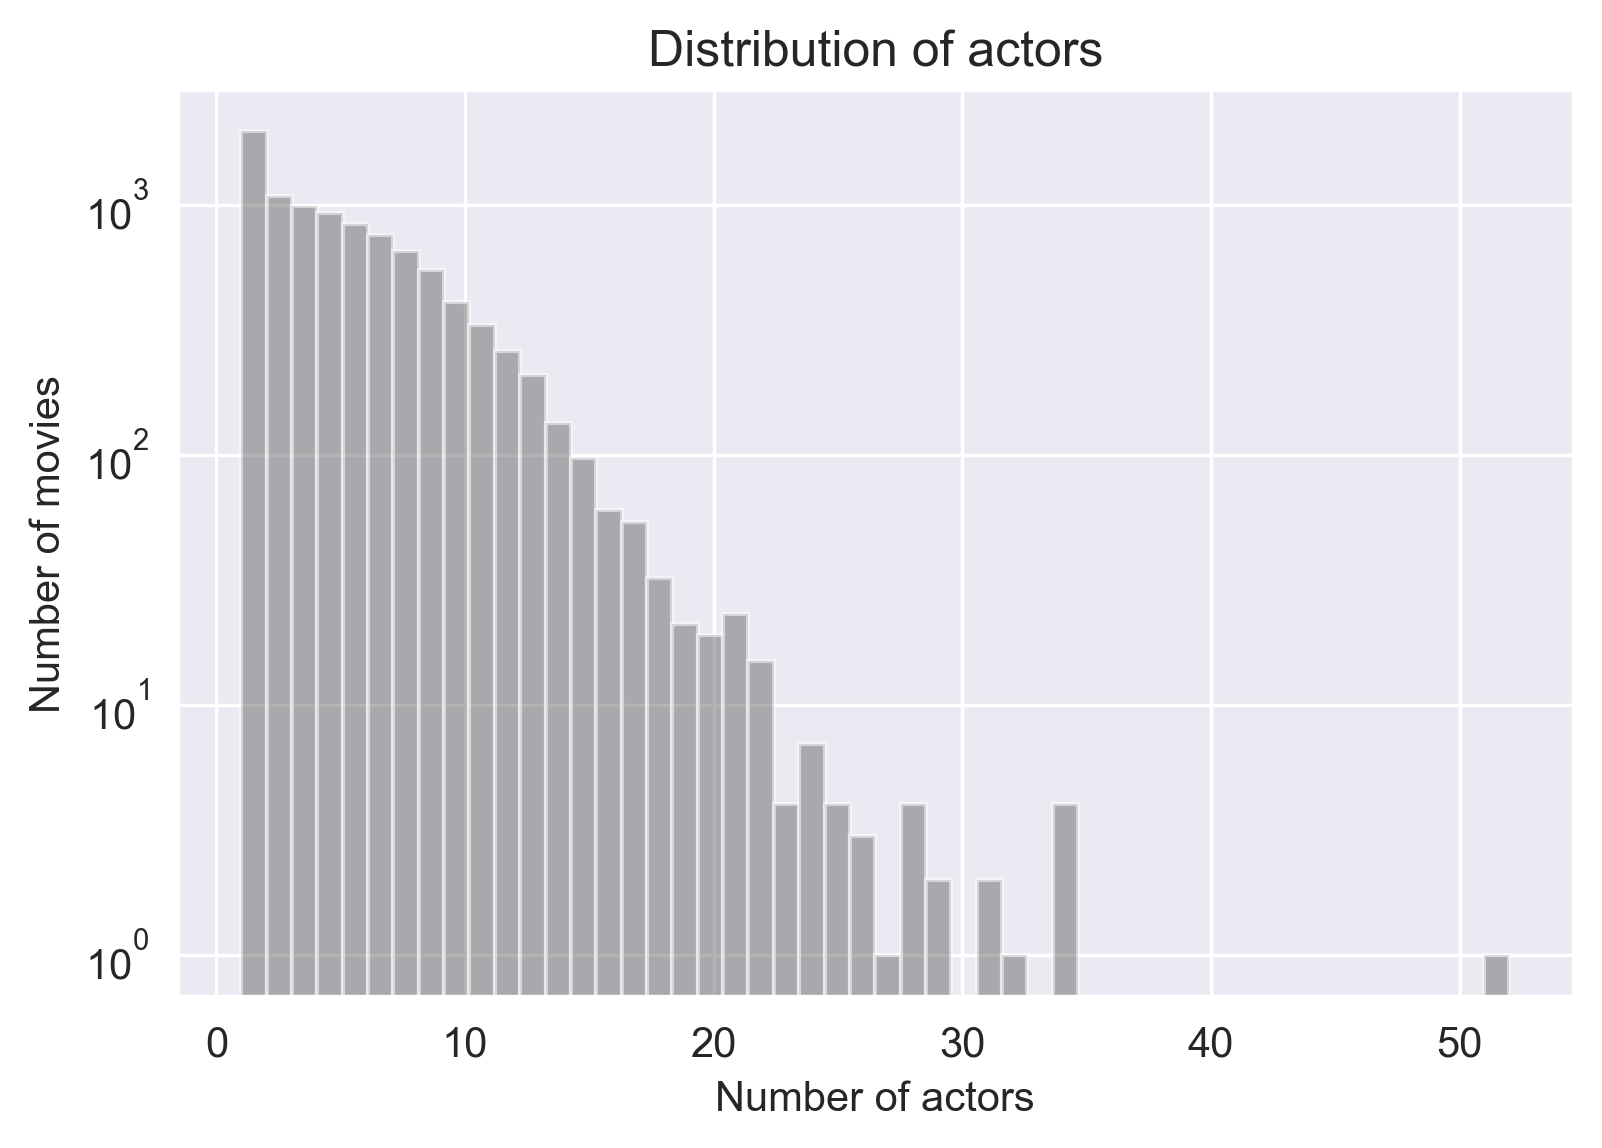

In [13]:
viz.visualize_actors_distribution(movies)

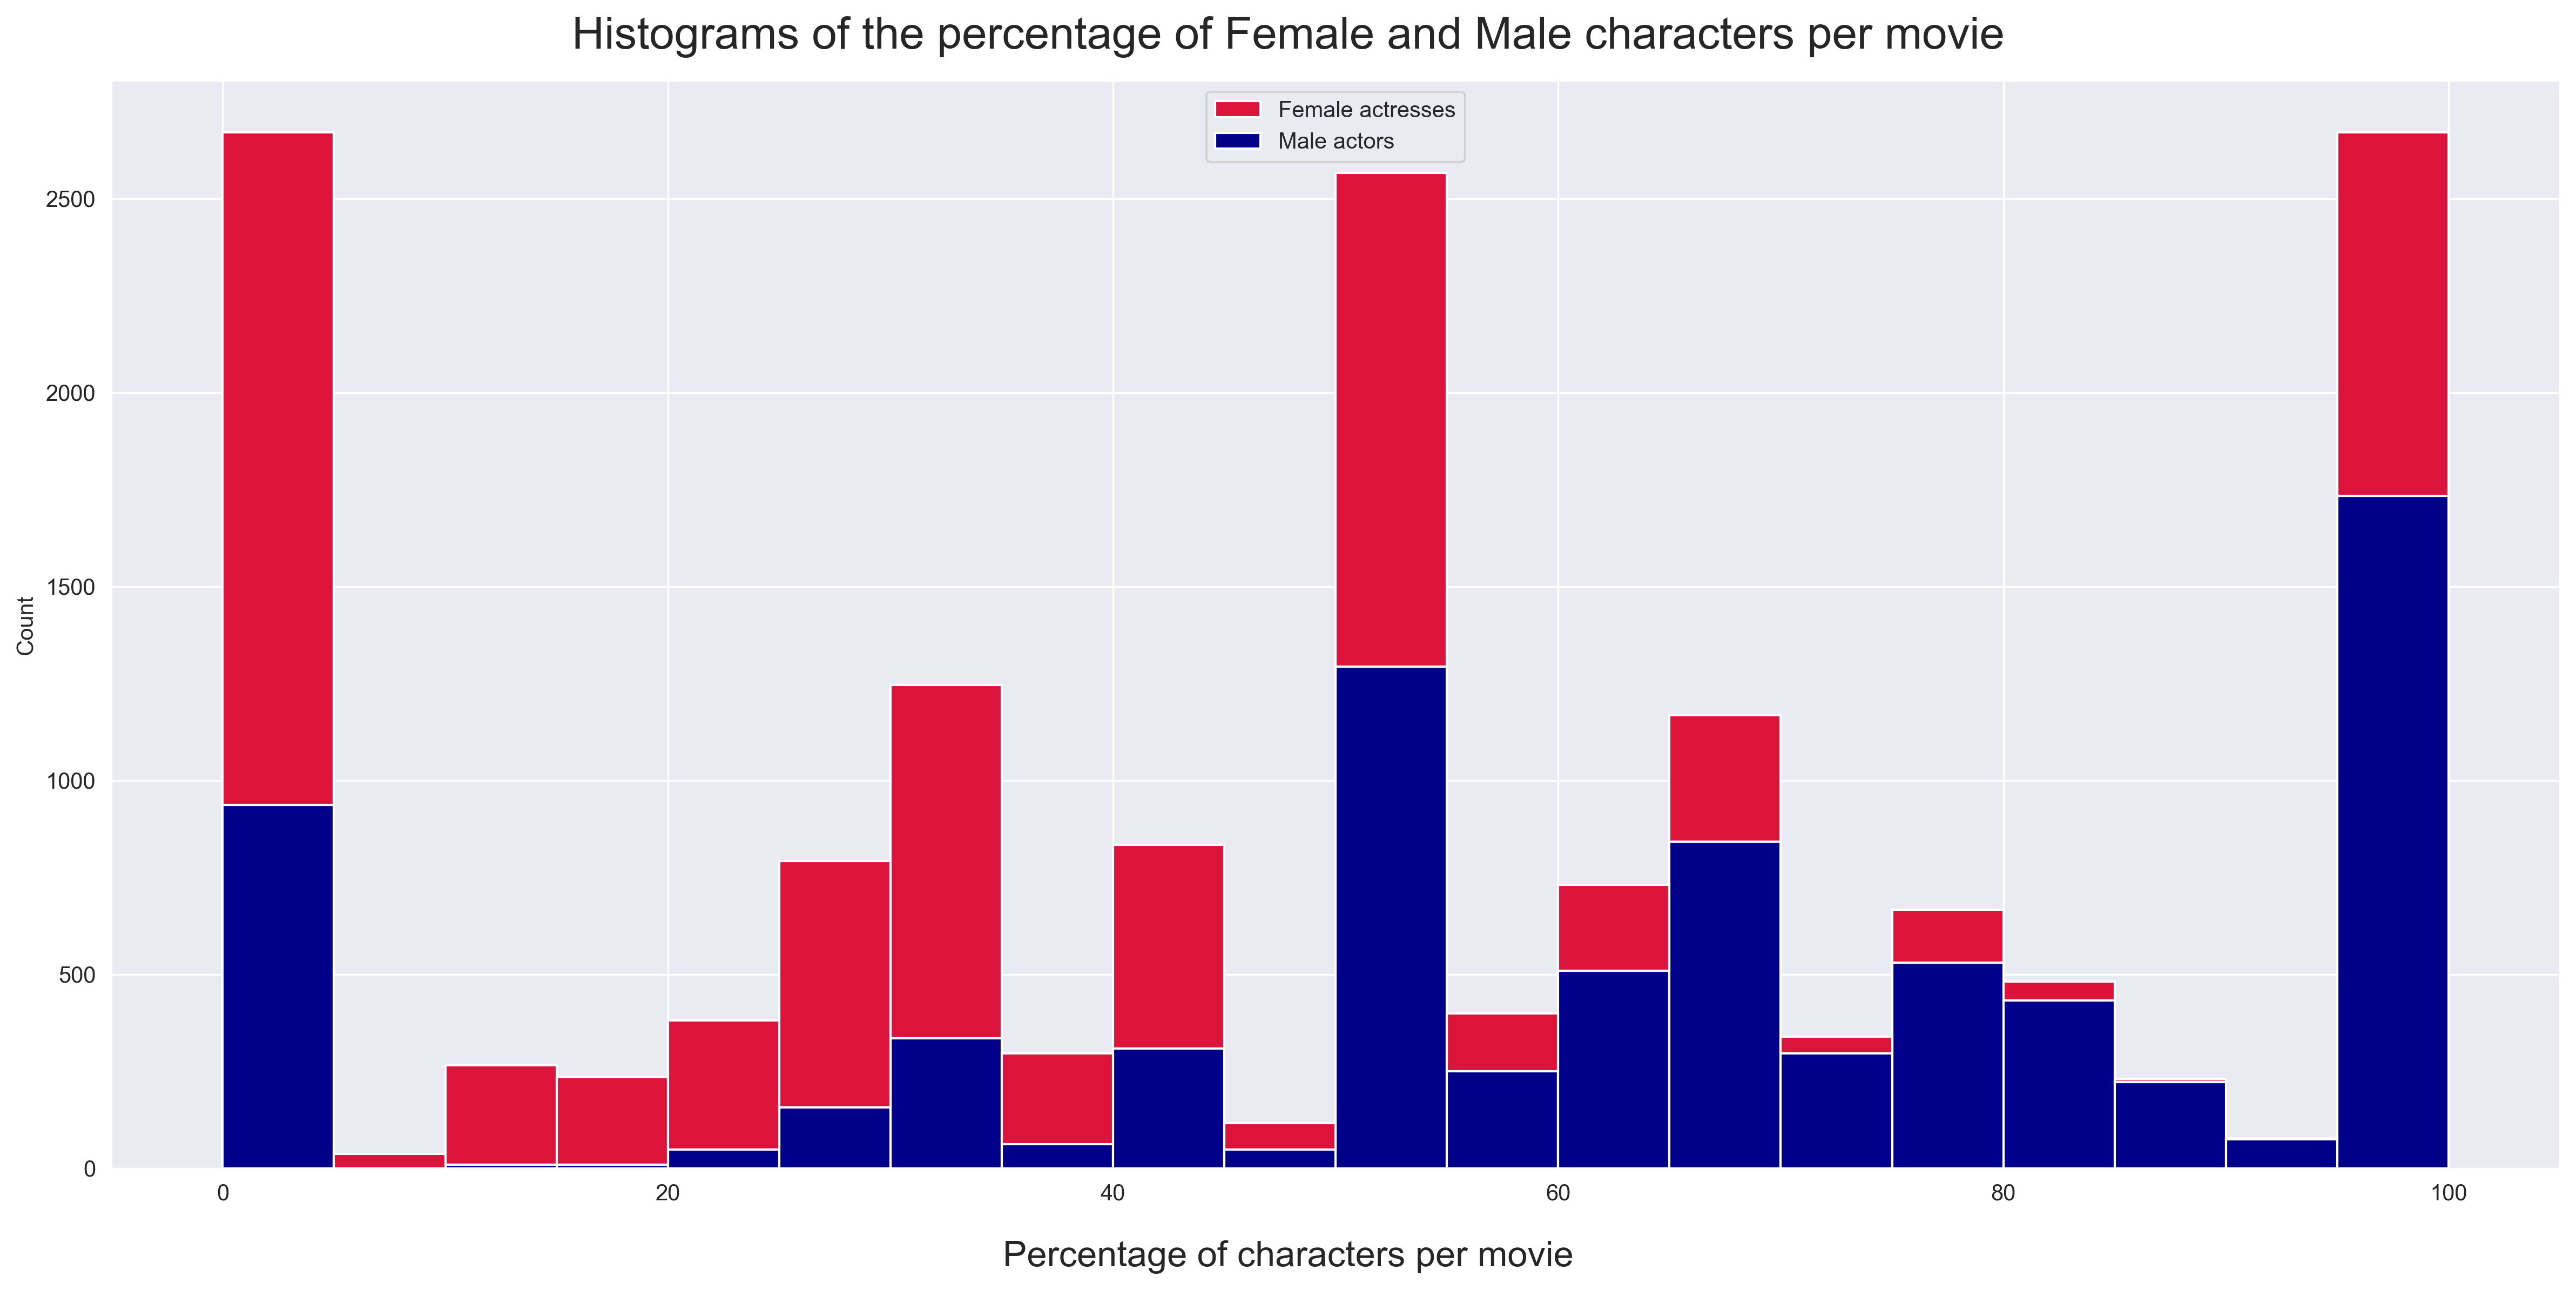

In [14]:
male_female_prop = viz.visualize_gender_prop(movies)

Here, it is evident that the proportion of movies with no women actors is significantly larger, while conversely, there is a substantial number of movies that feature only male actors.


## 4. Is there a link between popularity and proportion of Women in a movie ?

In [15]:
movies_gender_prop = pd.merge(movies, male_female_prop, on=["wikiID", "year"])
movies_gender_prop.drop_duplicates(subset=["movie_title"], inplace=True)

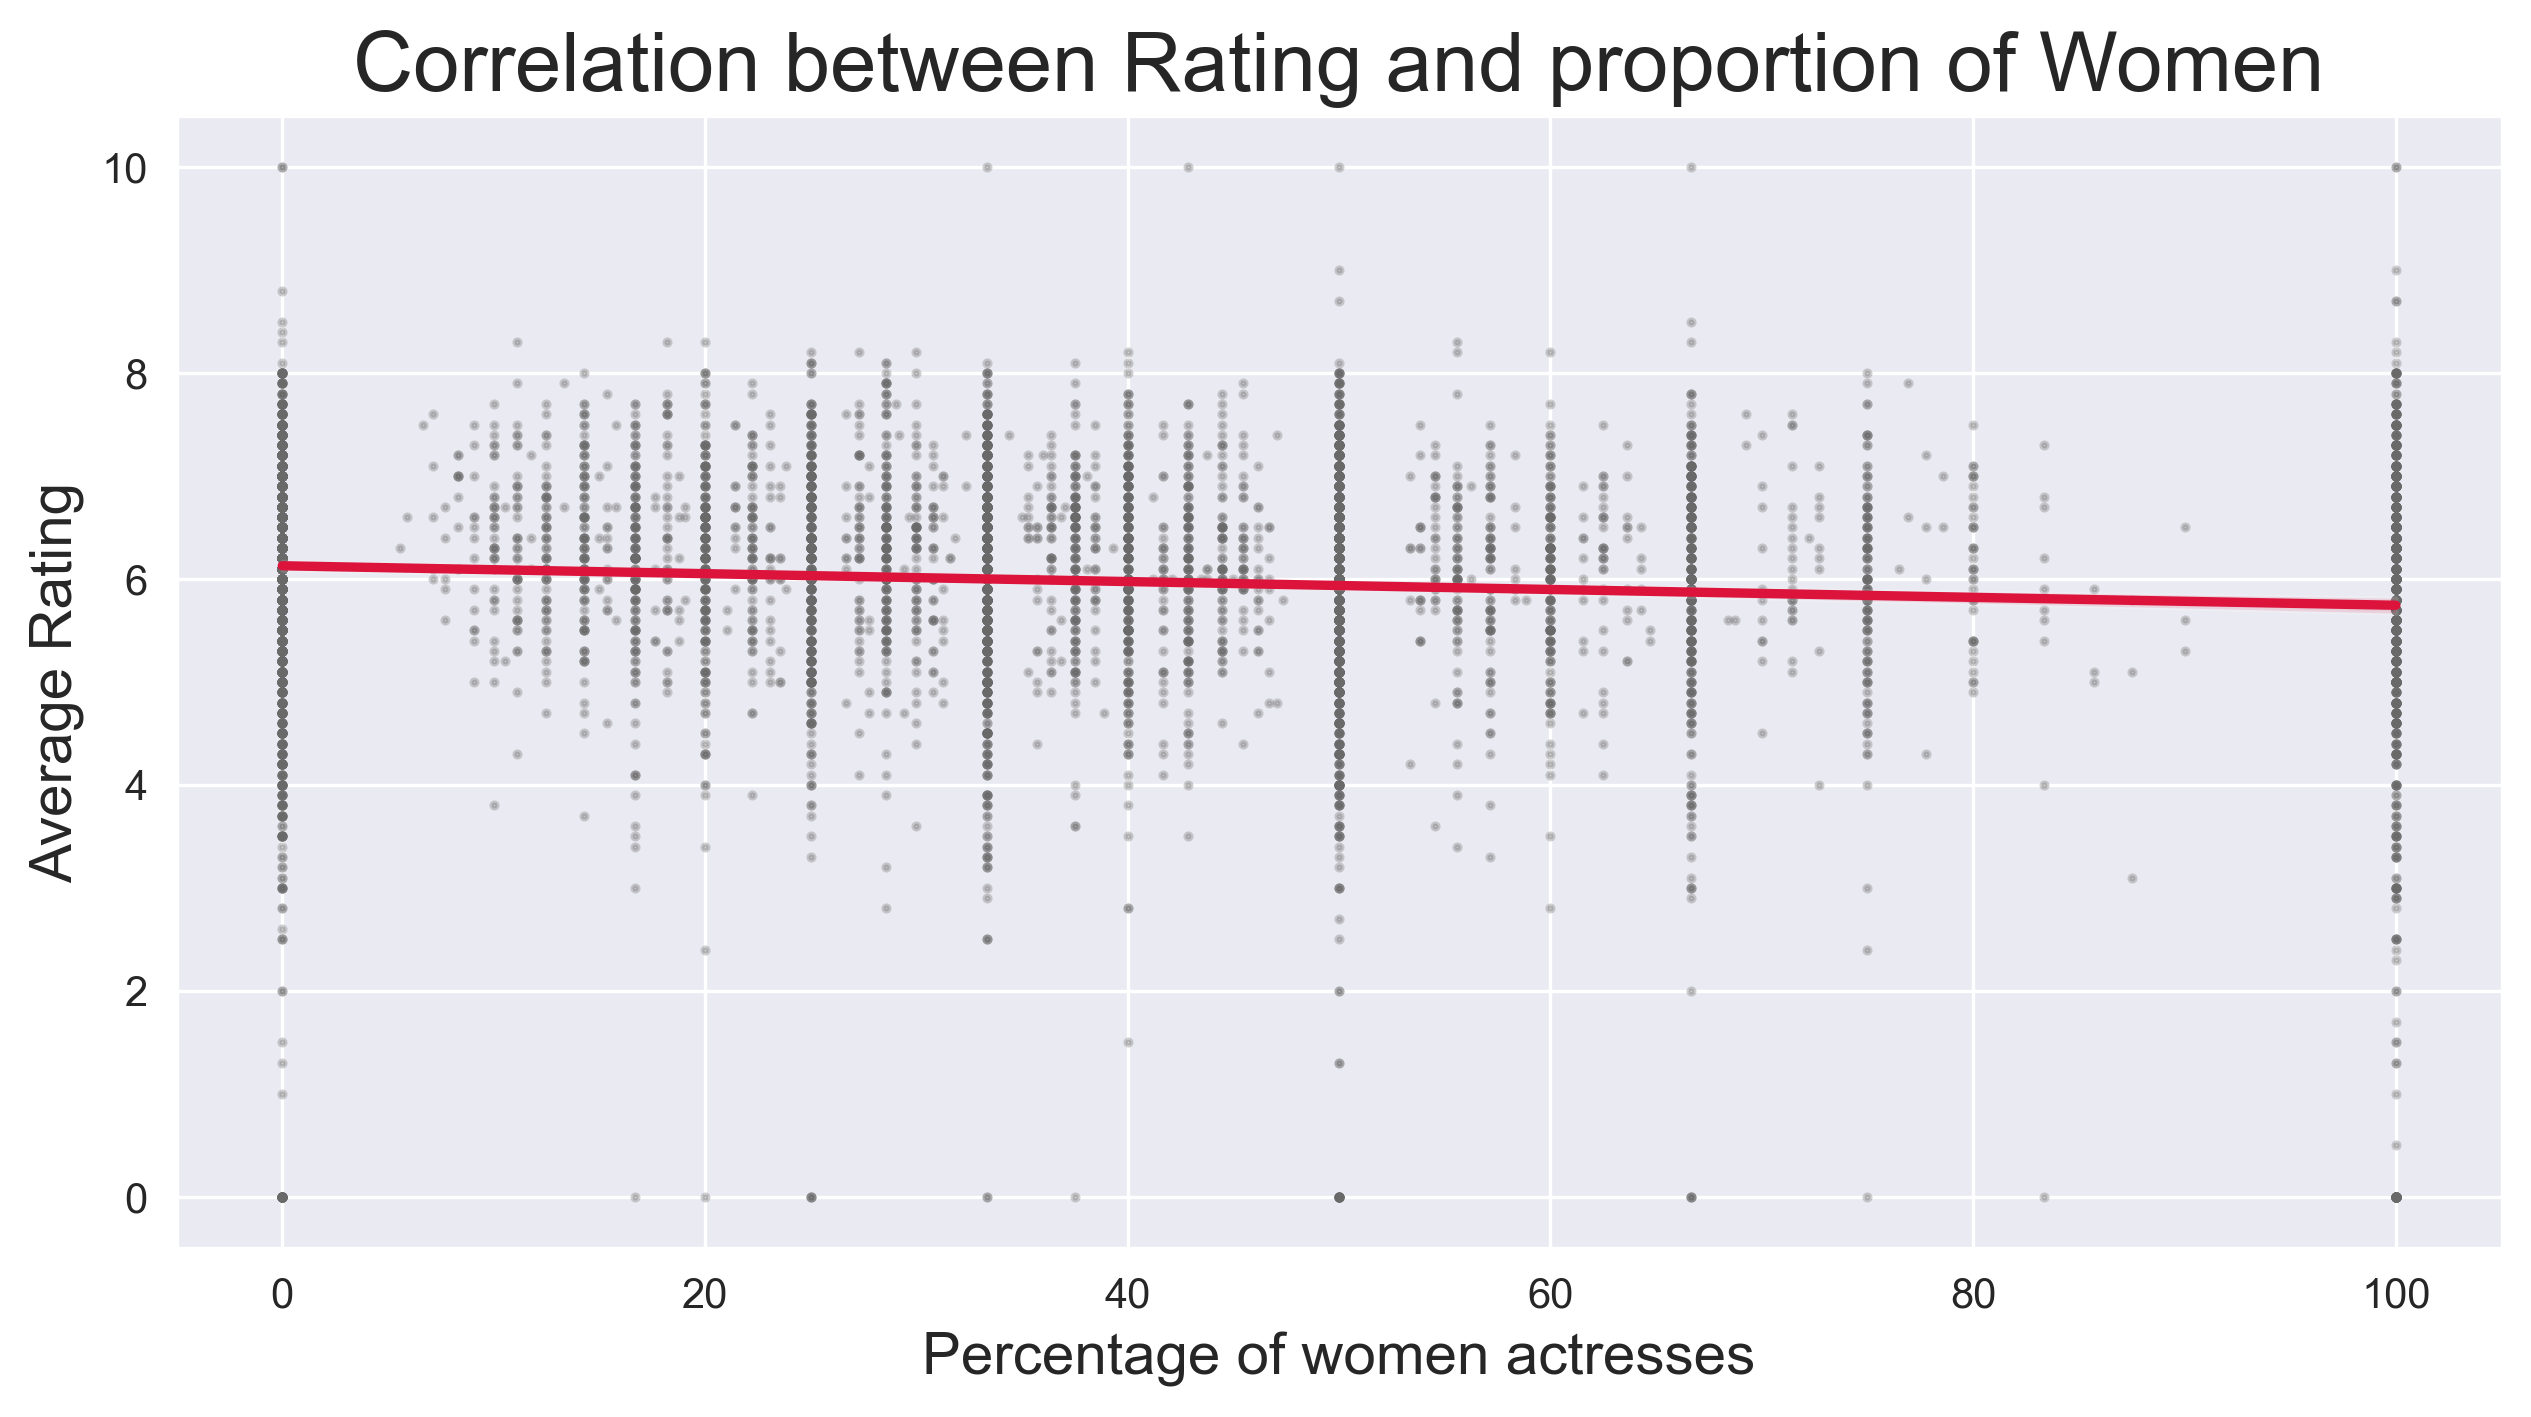

In [16]:
movies_gender_prop = movies_gender_prop.sort_values(
    by="percents_of_female", ascending=True
)

viz.visualize_regression(movies_gender_prop)

We can observe a slight negative correlation, indicating that a movie that highlights women more is less well-received by the audience.

In [17]:
# Compute Pearson Correlation between the popularity and the % of female actresses
print(
    stats.pearsonr(
        movies_gender_prop["percents_of_female"].astype(float),
        movies_gender_prop["popularity"].astype(float),
    )
)

# Compute Pearson Correlation between the vote average and the % of female actresses
print(
    stats.pearsonr(
        movies_gender_prop["percents_of_female"], movies_gender_prop["vote_average"]
    )
)

PearsonRResult(statistic=-0.12351611128750027, pvalue=3.350447115081439e-28)
PearsonRResult(statistic=-0.09974324194789246, pvalue=6.65552099098636e-19)


**Conclusion** : Since the $p$-value is low, the result is significative and one can deduce a negative correlation between the proportion of female and the success of a movie. This is already useful to know since it will be used in milestone P3

## 5. Is there a difference regarding age between men an women ?

### 5.1 Average Difference ? 

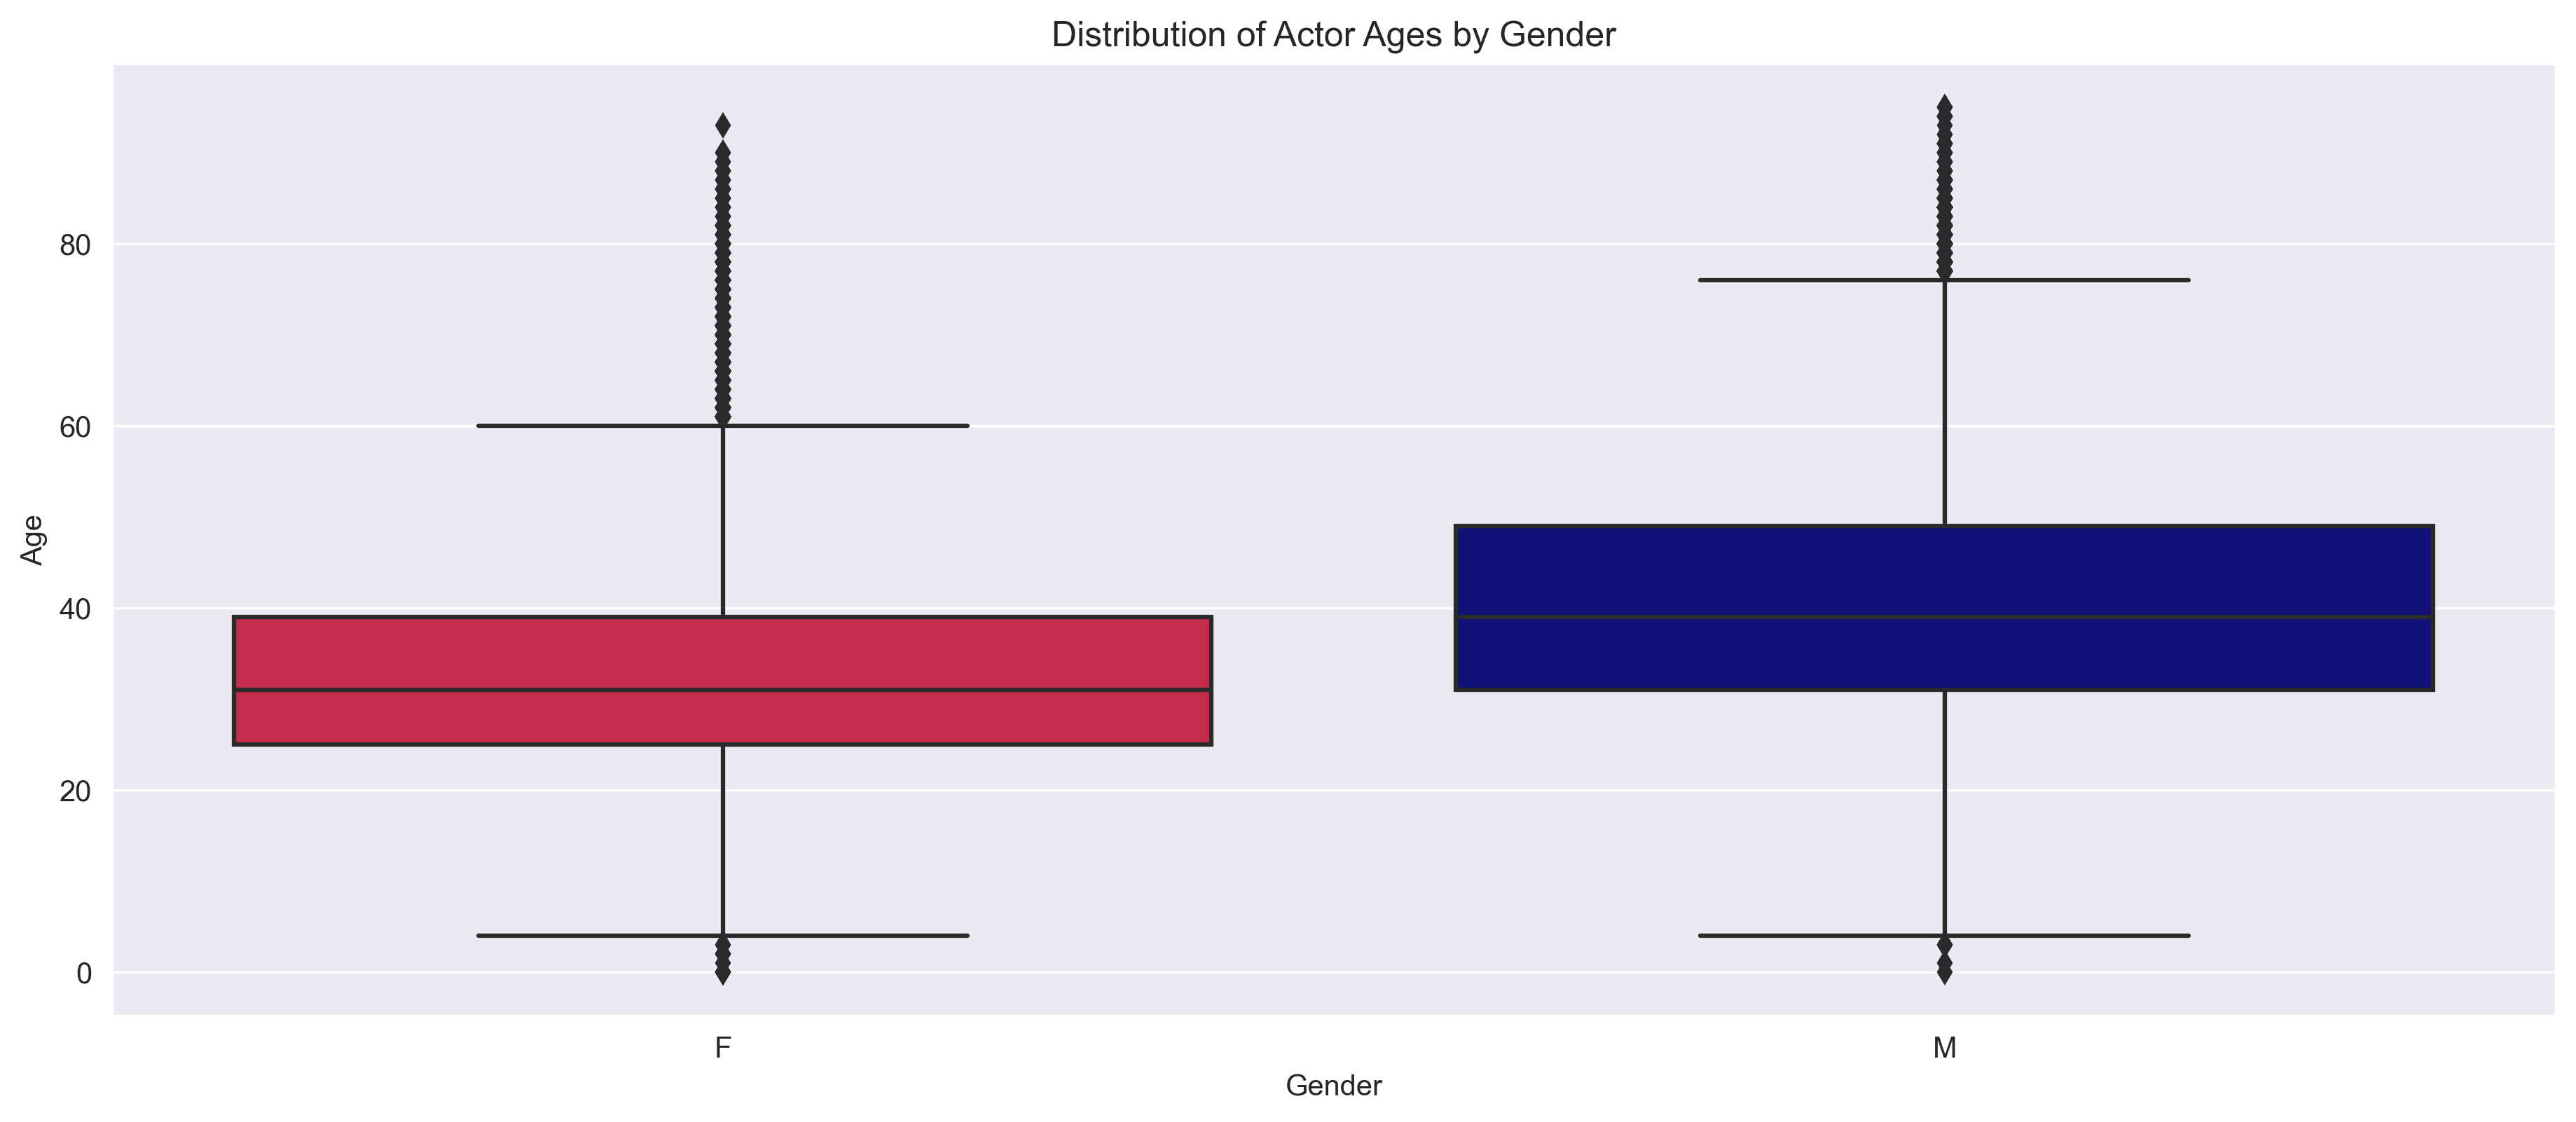

In [18]:
viz.visualize_age_distribution_by_gender(movies)

We can observe that men are older in average. Let's make a $T$-test to see if the difference is significant.

In [19]:
women_age = movies[movies["actor_gender"] == "F"]["actor_age_at_movie_release"]
men_age = movies[movies["actor_gender"] == "M"]["actor_age_at_movie_release"]

# T-test to determine if the difference in age between men and women is statistically significant
print(stats.ttest_ind(women_age, men_age, nan_policy="omit"))

Ttest_indResult(statistic=-64.4341922378515, pvalue=0.0)


The results of the $T$-test suggest that there is a statistically significant difference in average age of actors ($p$-value < 0.05). As the $T$-statistic is strongly negative (-64), we conclude that actresses are significantly younger than male actors.

### 5.2 Evolution of age distribution in the movie industry

AttributeError: 'Line2D' object has no property 'errorbar'

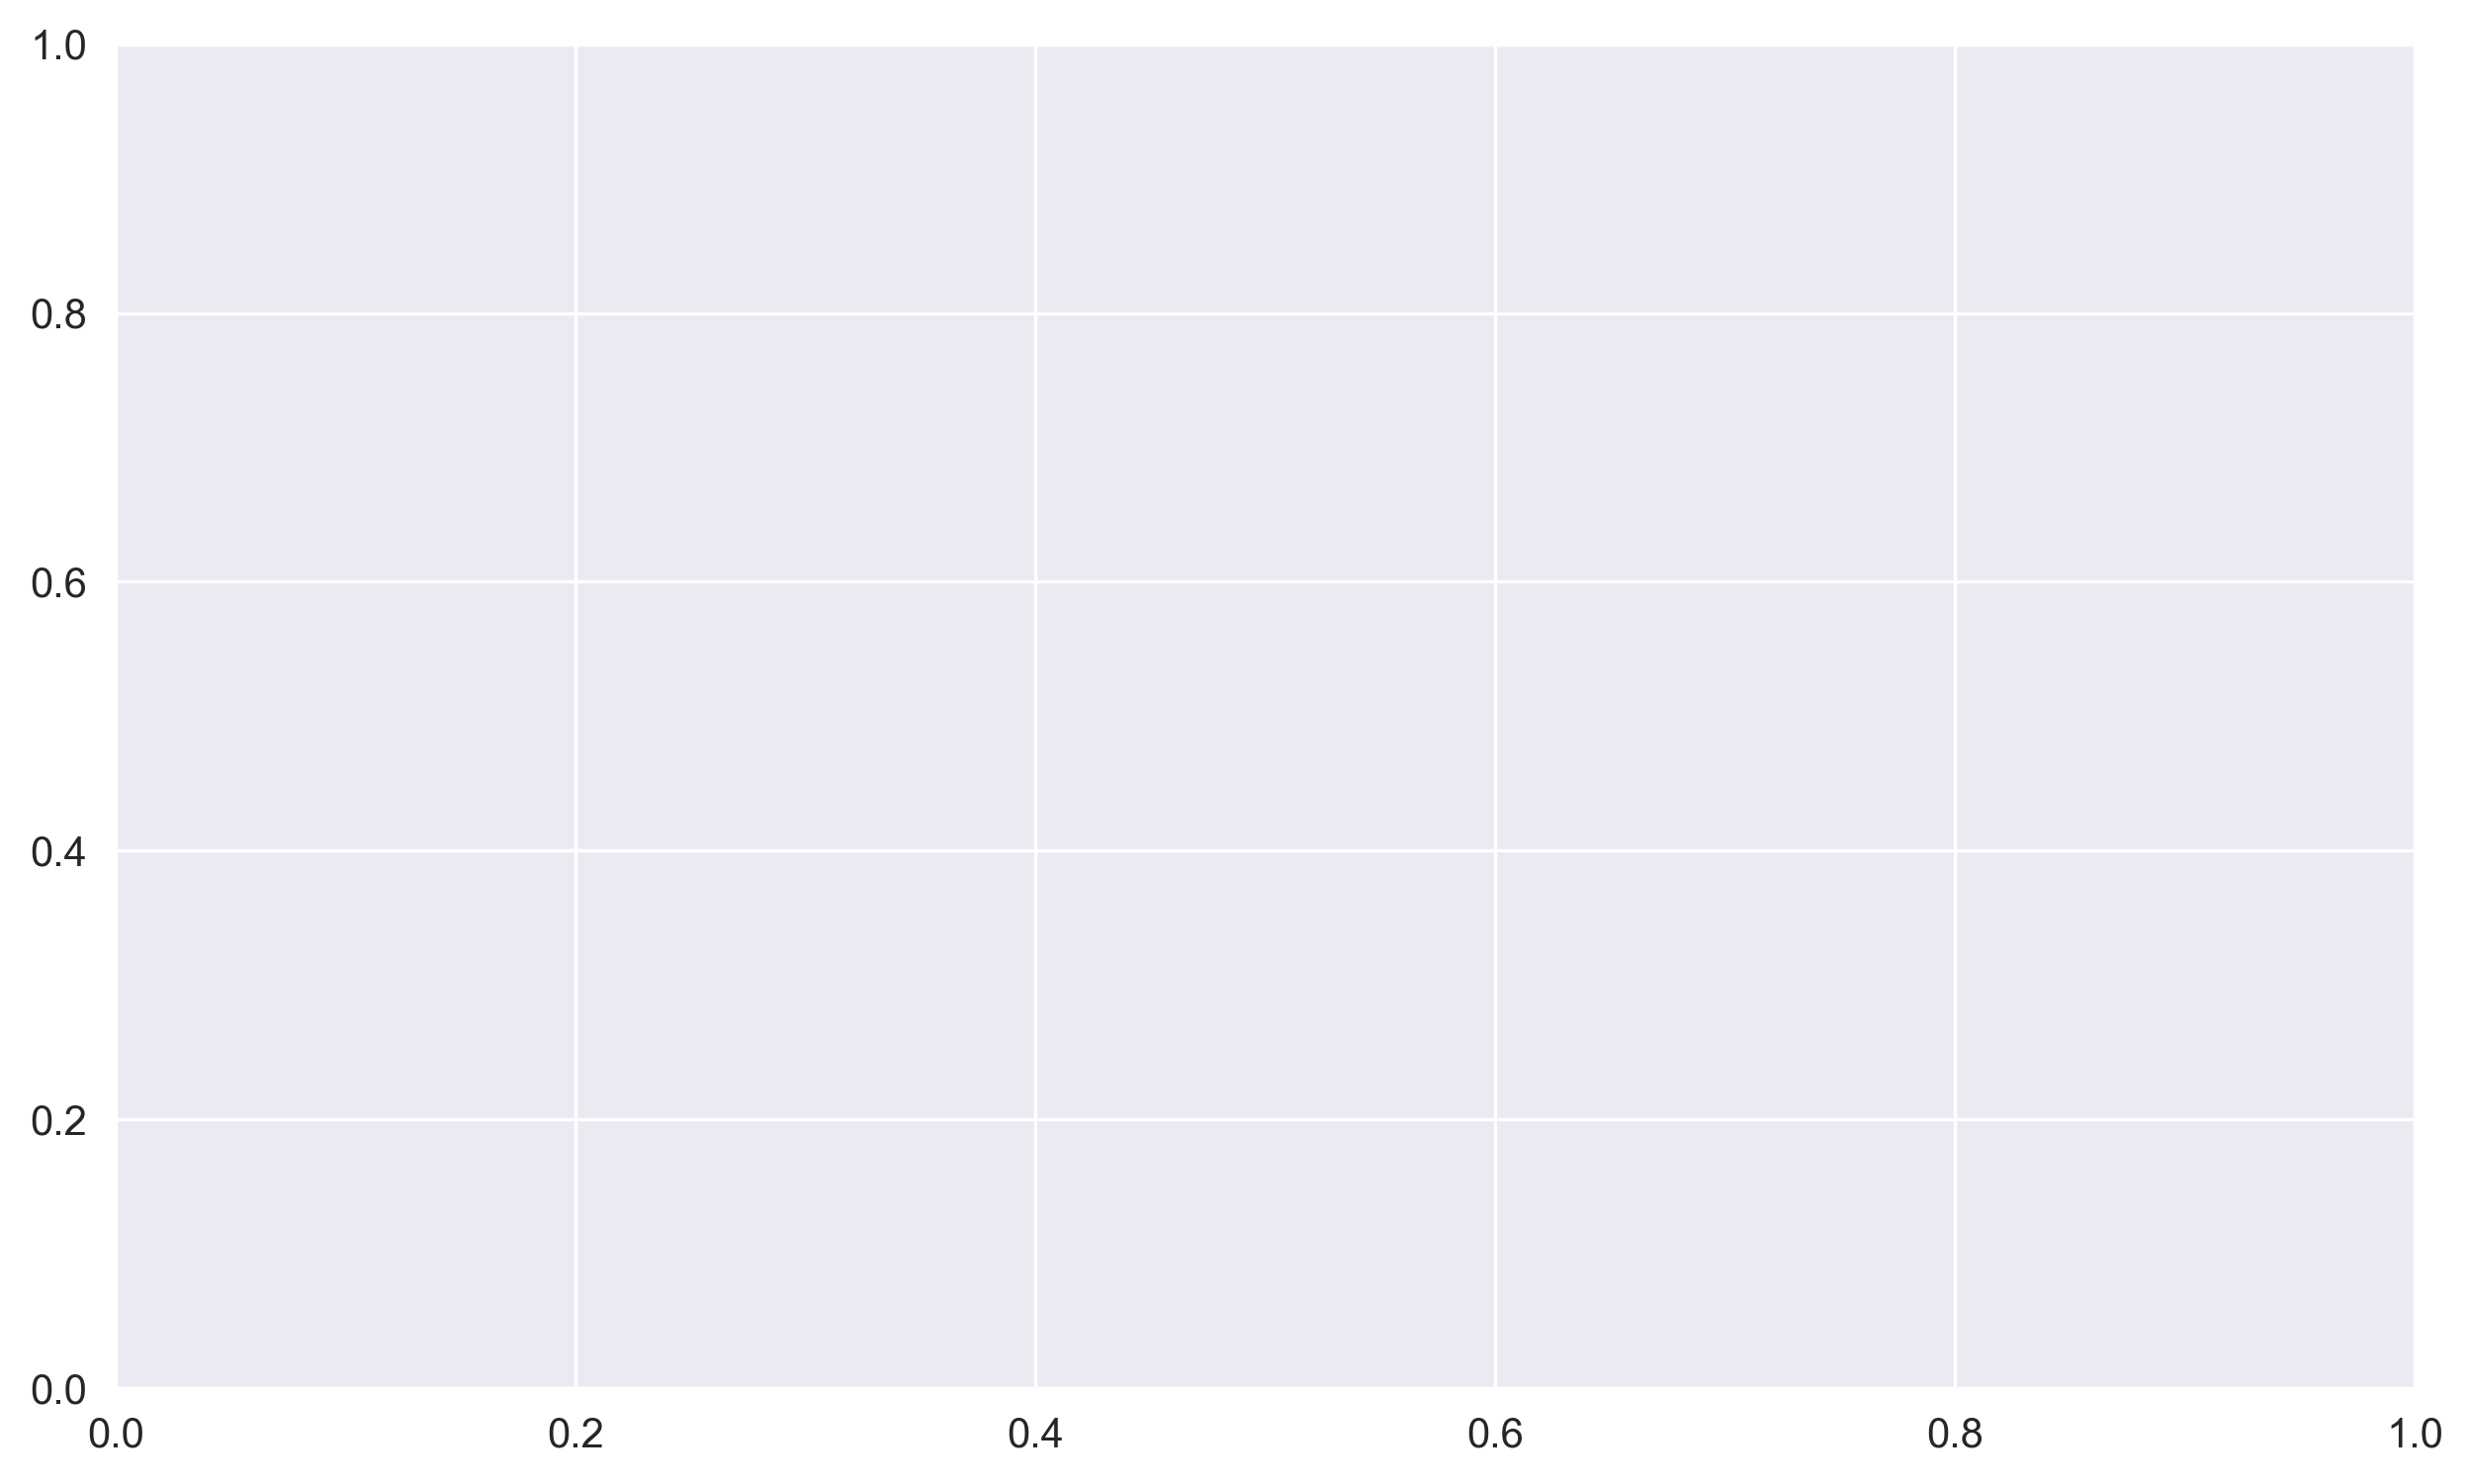

In [20]:
viz.visualize_age_evolution(movies)

In [ ]:
movies

It's noticeable that from the 1920s onward, the film industry tends to depict male actors who are older than their female counterparts.

## 6. Bechdel test

In this section we will start exploring the Bechdel dataset.

In [ ]:
bechdel_unique = viz.visualize_bechdel_distribution(movies_with_bechdel)
print(
    f"The Bechdel dataset originally contains around 10'000 movies while when it is merged with the normal movies dataset, it contains only {len(bechdel_unique)} movies."
)

We see, with no surprize, that most movies entered in the Bechdel test are from the 2000s.

---

# NLP on Plot Summaries

The goal here is to preprocess the summaries by tokenizing them and then conduct an initial analysis of the "feminism" aspect in the summaries by calculating a basic "femininity score." More in-depth analyses, including sentiment analysis, will be carried out in milestone P3.



## 1. Preprocessing of the texts and cleaning

In [ ]:
nlp_summaries = movies[["wikiID", "movie_title", "summary"]].drop_duplicates()
display(nlp_summaries)

Here, we apply the `clean_text()` from our `nlputils` module which clean the summaries by 

- converting all text to lowercase
- removing any text within square brackets (e.g. citations)
- removing all punctuation
- removing any words containing numbers
- removing any stop words (common words like "the", "and", etc.)

In [ ]:
nlp_summaries["summary"] = nlp_summaries["summary"].apply(nlputils.clean_text)
display(nlp_summaries.sample(2))

### 1.1 Tokenization

This step conducts a simple tokenization of summaries.

In [ ]:
nlp_summaries = nlputils.nlp_tokenize_summaries(nlp_summaries)
display(nlp_summaries.sample(2))

## 2. Gender score analysis

### 2.1 Compute feminity and masculinity score

Here we compute (a rather simplistic) femininity/ masculinity score of summaries using a list of [words designating females](./nlp/female_keywords.txt) and a list of [words designating males](./nlp/male_keywords.txt)

In [ ]:
pd.set_option("display.max_columns", None)
women_nlp_summaries = nlputils.nlp_compute_feminity_score(nlp_summaries.copy())
men_nlp_summaries = nlputils.nlp_compute_masculinity_score(nlp_summaries.copy())

women_nlp_summaries = pd.merge(women_nlp_summaries, male_female_prop, on=["wikiID"])
men_nlp_summaries = pd.merge(men_nlp_summaries, male_female_prop, on=["wikiID"])

print(
    stats.pearsonr(
        women_nlp_summaries["feminity_score"], women_nlp_summaries["percents_of_female"]
    )
)

print(
    stats.pearsonr(
        men_nlp_summaries["masculinity_score"], women_nlp_summaries["percents_of_male"]
    )
)

In both case, the $p$-value is greater than 0.05 and the Pearson correlation coefficient is very small, indicating that we cannot reject the null hypothesis that there is no correlation between the proportion of men/women and the plot summary. Further analysis is required (will be done in milestone P3).

### 2.2 Distribution of feminity/masculinity score

In [ ]:
viz.visualize_feminity_score_distribution(women_nlp_summaries)

As we can observe, there are numerous movies with a low femininity score, which confirms the findings of the previous test. It's also important to note that the femininity score is not perfect and rather simplistic. This will be enhanced in milestone P3.

In [ ]:
viz.visualize_masculinity_score_distribution(men_nlp_summaries)